In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import random
import os

from sklearn.model_selection import train_test_split

from keras import Input, layers, optimizers
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense,Dropout, LeakyReLU
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.utils import to_categorical

from lib.data.flickr_dataset import FlickrDataset
from lib.data.feature_vector_generator import FeatureVectorGenerator
from lib.data.generator.data_generator import DataGenerator

from lib.model.model_wrapper import ModelWrapper
from lib.model.model_utils import get_best_weights_file_from, get_loss_model_weights_path
from lib.model.metrics import rmse
from lib.model.search.search_factory import SearchFactory
from lib.model.search.beam_search_k_finder import BeamSearchKFinder, random_samples

from lib.utils.word_utils import word_to_index_and_index_to_word
from lib.utils.file_utils import create_directory
from lib.utils.plot_utils import show_sample, display_table
from lib.utils.array_utils import column
from lib.utils.pickle_utils import save_obj, load_obj

from keras.callbacks                         import ModelCheckpoint
from lib.callback.metric_plotter             import MetricsPlotter
from lib.callback.adam_learning_rate_tracker import AdamLearningRateTracker
from keras.callbacks                         import ReduceLROnPlateau

from lib.model.inspector.prediction_inspector_factory import PredictionInspectorFactory

from lib.utils.file_utils import lines_from 
from lib.utils.dict_utils import values_of

from lib.data.word_embedding import WordEmbedding

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Image captioning model

## Common parameters

What dataset we are going to use?

In [3]:
dataset_name='flickr8k' # Flickr8k
# dataset_name='flickr30k' # Flickr30k

Each line of dataset contain an image_path + separator + a descrption. Next regex are used to separate these:

In [4]:
line_separator = { 
    'flickr8k': r'#[0-9]', # Flickr8k
    'flickr30k': r'\| [0-9]\|' # Flickr30k
}

Dataset data file & iamges paths:

In [5]:
dataset_path            = f'./dataset/{dataset_name}'
data_path               = f'{dataset_path}/data'
train_set_ids_path      =  f'{dataset_path}/train_set_ids'
validation_set_ids_path =  f'{dataset_path}/validation_set_ids'
test_set_ids_path       =  f'{dataset_path}/test_set_ids'
images_path             = f'{dataset_path}/images'

What word embedding we are going to use?

In [6]:
# embeding_name = 'glove.6B.300d'
embeding_name = 'glove.42B.300d'
# embeding_name = 'glove.840B.300d'

word_embedding_path = f'./embedding/{embeding_name}.txt'

Embedding word vector size: This depend of embedding file, ins this case is 300.

In [7]:
embedding_vector_dim = 300

Path's where we save images and words embeddings:

In [8]:
image_features_path = f'{dataset_path}/img_features.pkl'
descrption_embedding_path = f'{dataset_path}/descrition_embeding.{embeding_name}.pkl'

Path where save model weights:

In [9]:
weights_path = create_directory(f'weights/{dataset_name}')
weights_file_path_patern = weights_path + '/weights__epoch_{epoch:02d}__loss_{loss:.4f}_val_loss_{val_loss:.4f}__rmse_{rmse:.4f}__val_rmse_{val_rmse:.4f}.h5'

Sample group files:

## Data preparation

Load dataset:

In [10]:
dataset = FlickrDataset(
    data_path, 
    images_path,
    desc_prefix='$', 
    desc_postfix='#',
    clean_desc=True,
    separator=line_separator[dataset_name]
)

Max len() desc: $ an africanamerican man wearing green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on busy sidewalk in front of group of men playing instruments #


In [11]:
dataset.max_desc_len()

34

In [12]:
samples = dataset.samples()

In [13]:
list(samples.values())[0].as_json()

<IPython.core.display.JSON object>

Separate sample in three groups:
* Train samples
* Validatiion samples
* Test sasmples

In [14]:
train_set_ids = lines_from(train_set_ids_path)
validation_set_ids = lines_from(validation_set_ids_path)
test_set_ids = lines_from(test_set_ids_path)

In [15]:
train_samples = values_of(samples, keys=train_set_ids)
validation_samples = values_of(samples, keys=validation_set_ids)
test_samples = values_of(samples, keys=test_set_ids)

Save sample groups. This step is very important, given that once model was train always must evaluate with same test samples selected before model train. 

In [16]:
print(f'Train: {len(train_samples)}, Val: {len(validation_samples)}, Test: {len(test_samples)}')

Train: 6000, Val: 1000, Test: 1000


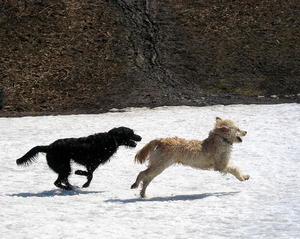

In [17]:
show_sample(train_samples[0])

### Generate images embedding 
This step evaluate all dataset images in **InceptionV3 model** with **imagenet weights** and get output from last convolutional layer. 
The idea is precalculate an "image embedding" to minimize the **image captionining model** train times. Save results to a file given that this process can take a long time.

In [18]:
if not os.path.isfile(image_features_path):
    image_paths = list(map(lambda it: it.path, samples.values()))
    image_features = list(FeatureVectorGenerator().generate(image_paths))
    save_obj(image_features_path, image_features)
else:
    image_features = load_obj(image_features_path)

print(f'Image embedding size: {len(image_features)} == Dataset size: {len(dataset.samples())}')
print(f'\nSample:\n- Image: {image_features[0][0]}\n- Embedding vector: {image_features[0][1]}')
image_features = dict(image_features)

Image embedding size: 8091 == Dataset size: 8092

Sample:
- Image: ./dataset/flickr8k/images/1000268201_693b08cb0e.jpg
- Embedding vector: [ 0.14066279  0.37648892  0.71698219 ...,  0.33690894  0.84069407
  1.16807771]


### Generate words embedding

Select words vocabulary:

In [19]:
word_min_occurs=10

vocabulary = dataset.words_set(min_occurs=word_min_occurs)
vocabulary.remove('tugofwar')

vocabulary_size = len(vocabulary)
complete_vocabulary_size = len(dataset.words_set())

In [20]:
print(f'Words(occurs>={word_min_occurs}): {vocabulary_size}/{complete_vocabulary_size}')

Words(occurs>=10): 1948/8766


Build **world to index*** and **index to world** dictionaries:

In [21]:
word_to_index, index_to_word = word_to_index_and_index_to_word(vocabulary)

index_to_word[0], index_to_word[1048], len(index_to_word)

('$', 'gives', 1948)

Build world embedding matrix: Save matrix to a file given that this process can take a long time.

In [22]:
if not os.path.isfile(descrption_embedding_path):
    embedding_generator = WordEmbedding.create(
       'glove',
       path=word_embedding_path, 
       vector_dim=embedding_vector_dim
    )
    embedding_matrix = embedding_generator.encode(word_to_index, vocabulary_size)
    save_obj(descrption_embedding_path, embedding_matrix)
else:
    embedding_matrix = load_obj(descrption_embedding_path)

print(f'Word embedding size: {len(embedding_matrix)}') 

Word embedding size: 1948


**Note**: In best case word embedding size is equal to vocabulary size. 

## Model build

In [34]:
def build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, optimizer, activation='leaky_relu', leaky_relu_alpha=0.1):
    img_feat_input = Input(name="Image_Feature", shape=(2048,))
    img_branch = Dropout(0.2)(img_feat_input)
    
    if activation == 'leaky_relu':
        img_branch = Dense(256)(img_branch)
        img_branch = LeakyReLU(alpha=leaky_relu_alpha)(img_branch)
    else:
        img_branch = Dense(256, activation='relu')(img_branch)
        
    seq_input = Input(name="Description_Sequence", shape=(dataset.max_desc_len(),))
    seq_branch = Embedding(vocabulary_size, embedding_vector_dim, mask_zero=True)(seq_input)
    seq_branch = Dropout(0.2)(seq_branch)
    seq_branch = LSTM(256)(seq_branch)

    decoder = add([img_branch, seq_branch])

    if activation == 'leaky_relu':
        decoder = Dense(256)(decoder)
        decoder = LeakyReLU(alpha=leaky_relu_alpha)(decoder)
    else:
        decoder = Dense(256, activation='relu')(decoder)

    outputs = Dense(name="Words_Distribution", units=vocabulary_size, activation='softmax')(decoder)

    model = Model(inputs=[img_feat_input, seq_input], outputs=outputs)

    model.layers[3].set_weights([embedding_matrix])
    model.layers[3].trainable = False

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=[rmse]
    )

    return ModelWrapper(model)

### Train model

Define hiperparameters uses to train each train step:

In [35]:
class Hiperparams:
    def __init__(self, **kwargs): self.__dict__ = kwargs

step_train_params = [
    Hiperparams(step = 1, epochs = 20, lr = 0.0001, batch_size = 3, factor = 0.2, patience = 1, weights_file = None),
    Hiperparams(step = 1, epochs = 10, lr = 0.00001, batch_size = 6, factor = 0.2, patience = 1, weights_file = None)
]

Builder data generators uses to generate train bacth and evalidation sets:

In [36]:
def build_train_val_data_generators(params):
    train_generator = DataGenerator(
        train_samples,
        image_features,
        word_to_index,
        index_to_word,
        dataset.max_desc_len(), 
        vocabulary_size,
        batch_size=params.batch_size
    )
    val_generator = DataGenerator(
        validation_samples,
        image_features,
        word_to_index,
        index_to_word,
        dataset.max_desc_len(), 
        vocabulary_size,
        batch_size=params.batch_size
    )
    return train_generator, val_generator

Build callbacks used to train model:
* ModelCheckpoint: Save model weights after each epoch.
* AdamLearningRateTracker: Show lerning rate.
* ReduceLROnPlateau: Use to avoid vanishing gradient.
* MetricsPlotter: Plot metrics.

In [40]:
def build_callbacks(val_generator, params):
    return [
        ModelCheckpoint(
            weights_file_path_patern,
            monitor='val_loss', 
            verbose=1,
            save_best_only=True, 
            save_weights_only=True, 
            mode='auto',
            period=1
        ),
        AdamLearningRateTracker(evaluate_interval=180),
        ReduceLROnPlateau(
            monitor  = 'val_loss',
            factor   = params.factor,
            patience = params.patience
        ),
        MetricsPlotter(
            val_generator, 
            plot_interval=220, 
            evaluate_interval=180, 
            batch_size=params.batch_size
        )
    ]

In [41]:
def get_weight_file(weights_path, params):
    if params.weights_file is None:
        try:
            return get_best_weights_file_from(weights_path)
        except:
            return None
    else:
        return params.weights_file

Train in model:

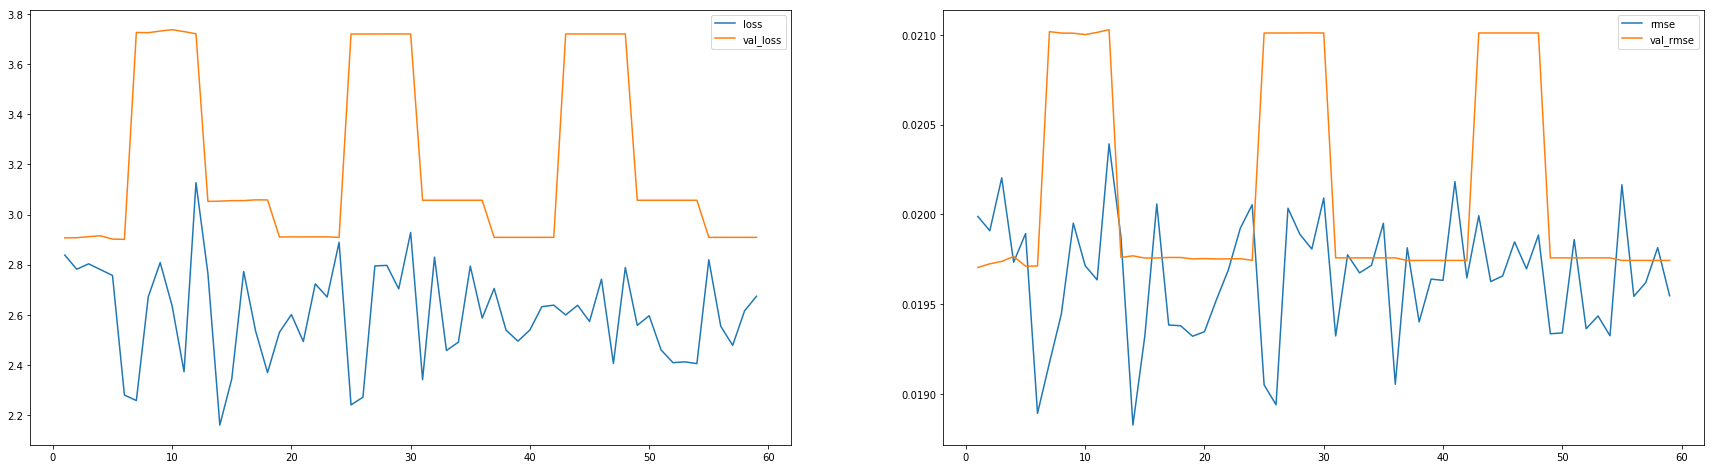

 901/1000 [==========================>...] - ETA: 6s - loss: 2.5724 - rmse: 0.0196

Learning rate (60): 0.000000000025600 (=)


Evaluate model (Each 180 steps):
331/331 [==============================] - 1s 2ms/step

Validation:
  - Loss (60): 2.908914 (⟱ 0.00000002)
  - Rmse (60): 0.019744 (⟱ 0.00000000)

Continue model train:
1000/1000 [==============================] - 73s 73ms/step - loss: 2.5737 - rmse: 0.0196 - val_loss: 3.2087 - val_rmse: 0.0204

Epoch 00010: val_loss did not improve from 3.20866


In [43]:
for params in step_train_params:
    train_generator, val_generator = build_train_val_data_generators(params)
    callbacks = build_callbacks(val_generator, params)
    
    model = build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, Adam(lr=params.lr))
    model.show()
    
    weight_file = get_weight_file(weights_path, params)
    if not weight_file is None:
        model.load(weight_file)
        
    steps_per_epoch=len(train_samples)/params.batch_size

    model.fit(train_generator, val_generator, epochs=params.epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)    

## Evaluate model

In [44]:
params = step_train_params[-1]
model = build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, Adam(lr=params.lr))

weight_file = get_weight_file(weights_path, params)
if not weight_file is None:
    model.load(weight_file)

./weights/flickr8k/weights__epoch_01__loss_2.5930_val_loss_3.2087__rmse_0.0196__val_rmse_0.0204.h5
Load weights from ./weights/flickr8k/weights__epoch_01__loss_2.5930_val_loss_3.2087__rmse_0.0196__val_rmse_0.0204.h5


### Best model output selection

We goning to use **beam search algorith** to try to improve model results selction a mode result from k prediction over the same input sample.

First of all we nett to found K value that improve model results: 

In [45]:
search_k_finder = BeamSearchKFinder(
    model=model,
    word_to_index=word_to_index,
    index_to_word=index_to_word,
    image_features=image_features,
    descriptions=dataset.descriptions(),
    max_seq_len=dataset.max_desc_len()
)

In [54]:
random_test_samples = random_samples(test_samples, 100)
k_values=range(1, 8)

In [55]:
metrics = search_k_finder.find(samples=random_test_samples, k_values=k_values)

K: 1, Mean WMDSim: 0.6057774357364597, Time: 0:00:17.628415
K: 2, Mean WMDSim: 0.6042022824525697, Time: 0:00:26.807847
K: 3, Mean WMDSim: 0.6030060136276919, Time: 0:00:37.211454
K: 4, Mean WMDSim: 0.6029956790603345, Time: 0:00:48.295346
K: 5, Mean WMDSim: 0.6031489373646557, Time: 0:00:57.986824
K: 6, Mean WMDSim: 0.6007976402757611, Time: 0:01:08.505286
K: 7, Mean WMDSim: 0.6010146150927375, Time: 0:01:23.170899


In [56]:
metrics.save()

Best K: 1



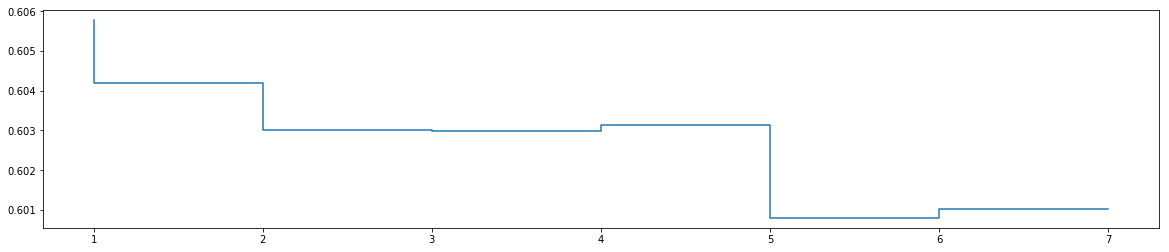

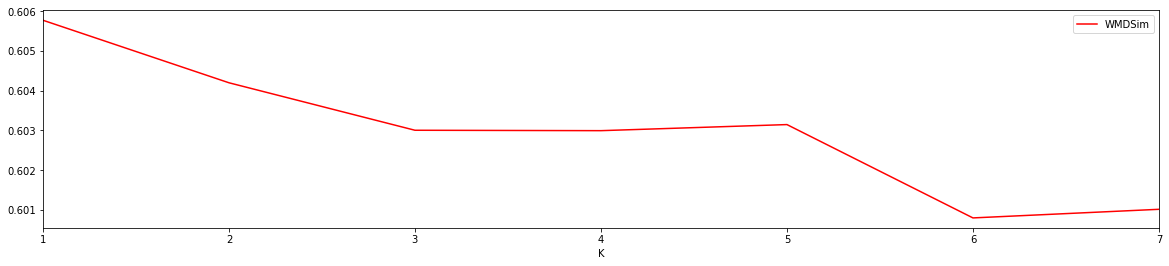

In [57]:
metrics.load()
metrics.show()

K: 1, Mean WMDSim: 0.581279843070029, Time: 0:00:06.794271
K: 2, Mean WMDSim: 0.6018934134789199, Time: 0:00:06.833846
K: 3, Mean WMDSim: 0.6091354399269588, Time: 0:00:09.305509
K: 4, Mean WMDSim: 0.6060807407639109, Time: 0:00:09.589979
K: 5, Mean WMDSim: 0.6060650943060728, Time: 0:00:11.519037
K: 6, Mean WMDSim: 0.6049506847864866, Time: 0:00:11.636836
K: 7, Mean WMDSim: 0.5980074756672059, Time: 0:00:12.338310
K: 8, Mean WMDSim: 0.597960772515864, Time: 0:00:14.308039
K: 9, Mean WMDSim: 0.604627145625747, Time: 0:00:15.613518
K: 10, Mean WMDSim: 0.595192051588926, Time: 0:00:16.226038
Best K: 3



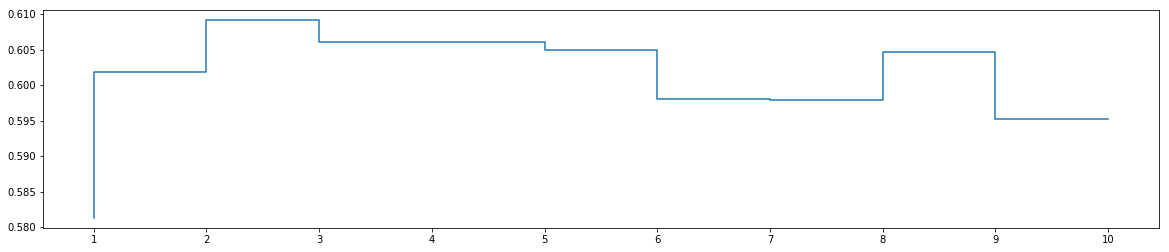

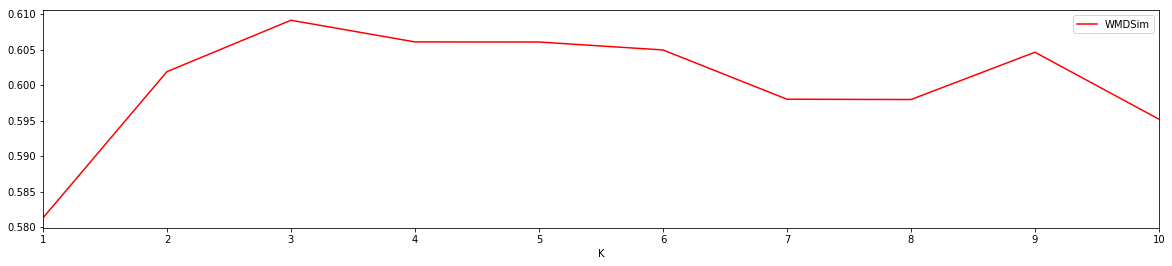

In [50]:
random_train_samples = random_samples(train_samples, 10)
k_values=range(1, 10 + 1)

metrics = search_k_finder.find(samples=random_test_samples, k_values=k_values)

metrics.show()

## Test model

In [58]:
class TestInspector:
    def __init__(self, k_values):
        self.inspectors = [(k, self.__create_inspector(k=k)) for k in k_values]

    def __create_inspector(self, k):
        return PredictionInspectorFactory.create_inspector(
            model,
            word_to_index,
            index_to_word,
            image_features,
            dataset.descriptions(),
            dataset.max_desc_len(),
            k,
            verbose=False
        )

    def inpect(self, sample):
        for k, inspector in self.inspectors:
            print(f'K={k}')
            inspector.inspect(sample)
        

K=1


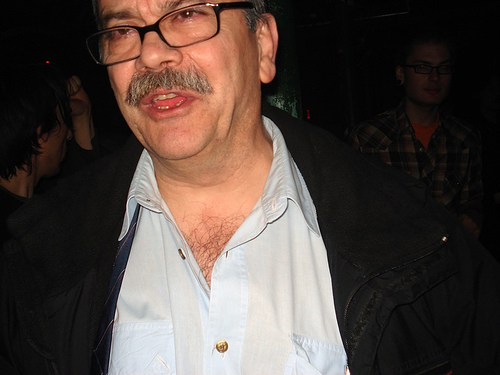

K=1


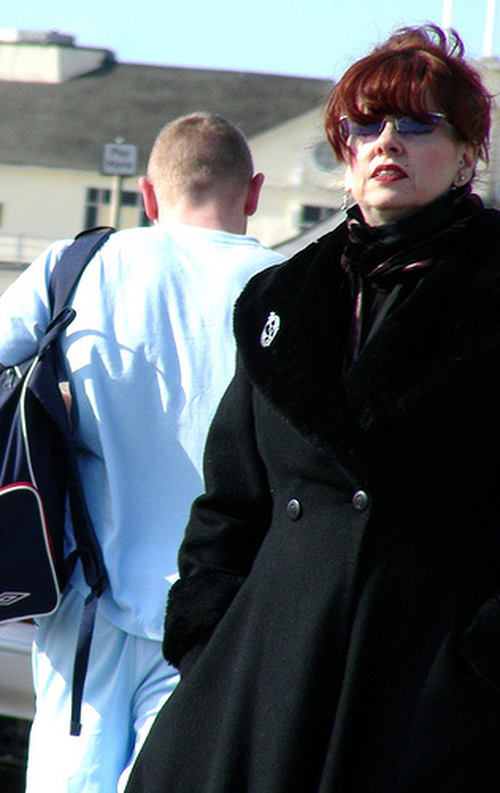

K=1


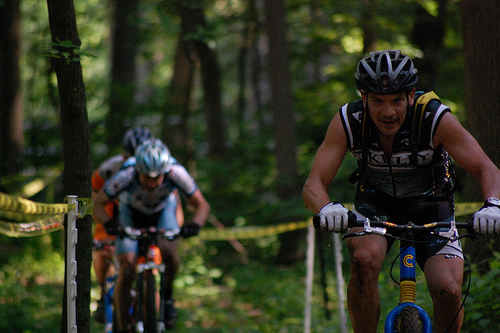

K=1


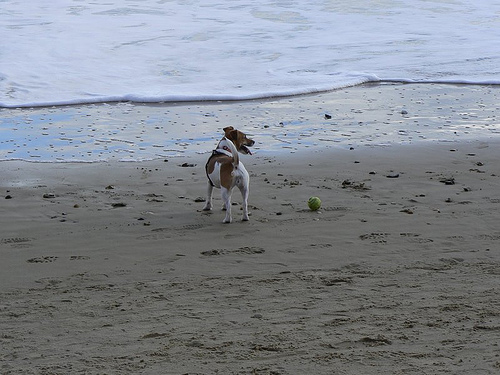

K=1


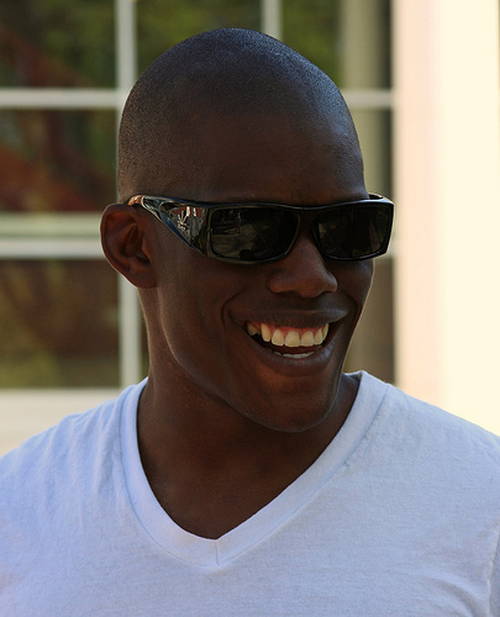

K=1


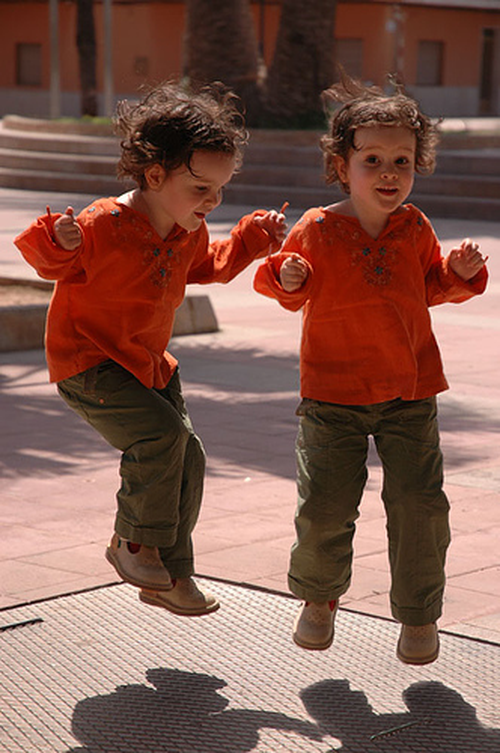

K=1


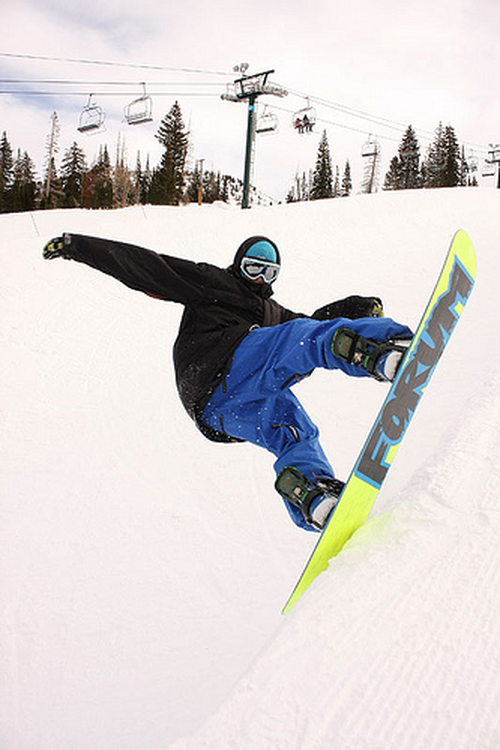

K=1


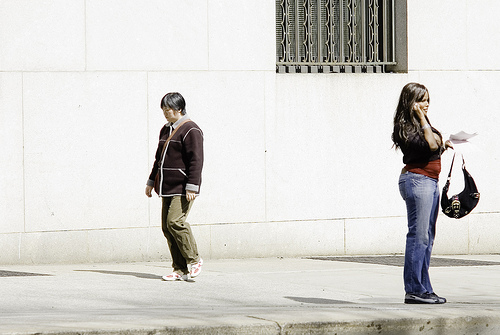

K=1


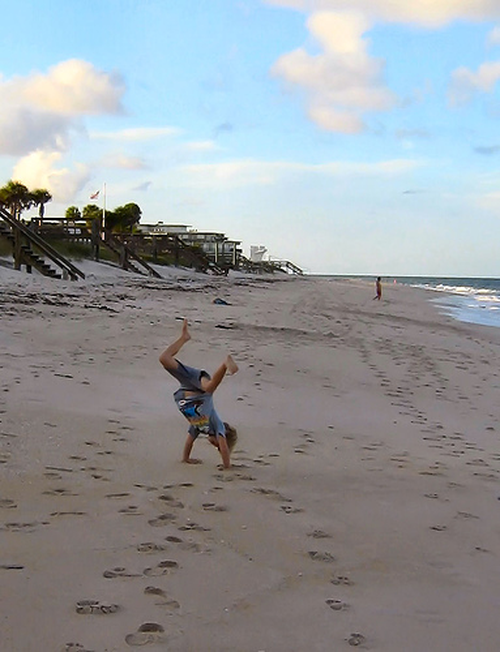

K=1


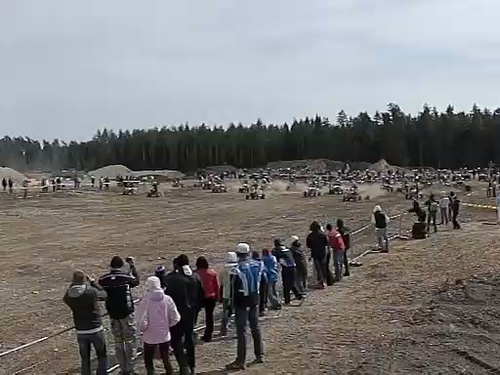

In [60]:
test_inspector = TestInspector(k_values=[metrics.best_k()])
for sample in random_samples(test_samples, 10):
    test_inspector.inpect(sample)